Use https://github.com/jfcrenshaw/auxtel_aos , in particular https://github.com/jfcrenshaw/auxtel_aos/blob/main/notebooks/example_auxtel_sim.ipynb
        
However, need to use perturbations defined by Zk coefficients - there's something similar here https://github.com/suberlak/AOS/blob/main/AOS_DM-34846_compensable.ipynb (although 

as well as https://github.com/jmeyers314/wfsim/blob/perturbations/notebooks/ts_wep%20demo%20on-axis.ipynb 



Need to first simulate the perturbations given Zernikes - 

In [2]:
!pip install galsim
!pip install danish
!pip install batoid

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for danish: filename=danish-0.1.5-cp310-cp310-linux_x86_64.whl size=66681 sha256=8f18336efd993e270e53c11ec7164279c4aae5f99925f351ac6f629ead8b4c72
  Stored in directory: /sdf/home/s/scichris/.cache/pip/wheels/63/61/3d/5106d716d7acc6dc27cd2868444a9b6a3c5c588def050c5ea9
Successfully built danish
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for batoid: filename=batoid-0.3.7-cp310-cp310-linux_x86_64.whl size=4604546 sha256=af15c3d62365f18a0761f0cab2cf7a7053ea38d3818b780d0d72f9c8fa9e4669
  Stored in directory: /sdf/home/

To get `wfsim` we can't just do `pip install` - that will pull a different `wfsim` (which has nothing to do with AOS). Instead, we need to do 


    git clone https://github.com/jmeyers314/wfsim.git

    cd wfsim 

    git lfs install

    git lfs pull

    python setup.py install --user  
    
    

In [120]:
import numpy as np # standard package for doing calculations
import matplotlib.pyplot as plt # standard package for plotting

import batoid
import galsim

import sys
sys.path.append('/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/wfsim/')
import wfsim

In [121]:
auxtel = batoid.Optic.fromYaml("AuxTel.yaml")

In [122]:
bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')

In [123]:
# parameters associated with the observing conditions
obs_params = {
    # zenith=0 means straight up, while zenith=90 is the horizon
    # greater zenith angle means more atmospheric turbulence
    "zenith": 30 * galsim.degrees,

    # raw_seeing sets how much atmospheric turbulence there is at zenith=0
    # wfsim uses this to calculate how much turbulence there is at 
    # the zenith angle given above
    "raw_seeing": 0.7 * galsim.arcsec,

    # these next three parameters set attributes of the atmosphere, which
    # help determine how much turbulence there is
    "temperature": 293, # Kelvin
    "pressure": 69, # kPa
    "H2O_pressure": 1, # kPa

    # wavelength of the observed light. this is important because light of 
    # longer/shorter wavelength refracts less/more in the atmosphere
    "wavelength": bandpass.effective_wavelength, # nanometers

    # the AuxTel exposure time
    "exptime": 30, # seconds
}

# parameters associated with computational aspects of simulating the atmosphere
atm_params = {
    "screen_size": 819.2,
    "screen_scale": 0.1,
    "nproc": 6,
}

In [124]:
seed = 0
rng = np.random.default_rng(seed)
# first lets select some random translations
# I will simulate an intrafocal image, so I subtract 0.8mm from the z translation


# Just a defocal shift
# M2_trans = np.array([0, 0, +0.0008]) # meters

# Random small shifts in x,y,z + defocal offset in z 
# M2_trans = np.array([
#     rng.uniform(-0.001, 0.001),  # meters
#     rng.uniform(-0.001, 0.001),
#     rng.uniform(-0.0001, 0.0001) - 0.0008,
# ])

# now lets's select some random rotations
# M2_rot = (
#     batoid.RotX(np.deg2rad(rng.uniform(-0.1, 0.1)/60)) @
#     batoid.RotY(np.deg2rad(rng.uniform(-0.1, 0.1)/60))
# )

# now let's create a copy of the AuxTel with these perturbations
# intra_perturbed = (
#     auxtel0
#     .withGloballyShiftedOptic("M2", M2_trans)
#     .withLocallyRotatedOptic("M2", M2_rot)
# )

# provide the modes as Zernikes 
M2_modes = rng.uniform(-1e-1, +1e-1, size=23) # waves
M2_modes *= bandpass.effective_wavelength * 1e-9 # meters

# This doesn't work - why ?? 
#M2_modes = [50, 0,0,0,0,0,0,0,0,0] # nm 

M2_surface_perturbation = batoid.Zernike(
    M2_modes,
    R_outer=0.6
)

# we apply the same surface perturbations to the telescope
# whether intra or extra focal ... 
perturbed = auxtel.withSurface(
    "M2",
    batoid.Sum([
        auxtel["M2"].surface,
        M2_surface_perturbation,]))




In [125]:
M2_modes*1e9

array([ 17.04678635, -28.65324444, -57.13222741, -60.17485813,
        38.99083709,  51.37317069,  13.272305  ,  28.56403802,
         5.42973677,  54.15081254,  39.31236655, -61.89110775,
        44.4839317 , -58.05176034,  28.58381352, -40.36916781,
        45.20266665,   5.16042535, -24.9286401 ,  -9.62265031,
       -58.70717534, -46.76317034,  21.23658083])

In [126]:
intra = perturbed.withGloballyShiftedOptic(
   "M2", [0, 0, -0.0008] 
)


extra = perturbed.withGloballyShiftedOptic(
   "M2", [0, 0, +0.0008] 
)


In [127]:
intra_simulator = wfsim.SimpleSimulator(
    obs_params,
    atm_params,
    intra,
    bandpass,
    shape=(4000, 4000),
    rng=rng
)

extra_simulator = wfsim.SimpleSimulator(
    obs_params,
    atm_params,
    extra,
    bandpass,
    shape=(4000, 4000),
    rng=rng
)

In [109]:
# choose a position for the star
# these angles specify the angle from the optical axis to the star
thx = np.deg2rad(0)
thy = np.deg2rad(0)

# create a spectrum for the star -- this is needed for chromatic refraction
# we will randomly select a plausible star temperature, 
# and calculate the corresponding blackbody spectrum
star_temp = rng.uniform(4_000, 10_000) # Kelvin
sed = wfsim.BBSED(star_temp) # wfsim has a function to calculate the blackbody spectrum

# randomly choose a flux (must be an integer)
flux = rng.integers(1_000_000, 2_000_000)


intra_simulator.add_star(thx, thy, sed, flux, rng)
extra_simulator.add_star(thx, thy, sed, flux, rng)

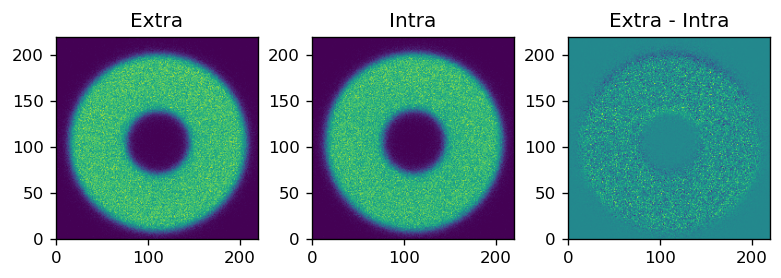

In [110]:
xcen,ycen = 1600,2000
dx,dy = 110,110
fig, axes = plt.subplots(1, 3, dpi=120, constrained_layout=True)

extra_stamp = extra_simulator.image.array[xcen-dx:xcen+dx, ycen-dy:ycen+dy]
intra_stamp = intra_simulator.image.array[xcen-dx:xcen+dx, ycen-dy:ycen+dy]
axes[0].imshow(extra_stamp, origin="lower")
axes[0].set_title("Extra",)# color="b")

axes[1].imshow(intra_stamp, origin="lower")
axes[1].set_title("Intra", )#color="b")

axes[2].imshow(extra_stamp-intra_stamp, origin="lower")
axes[2].set_title("Extra - Intra",)# color="w")

#for ax in axes:
#    ax.set(xticks=[], yticks=[])

plt.show()


What was the truth? 

In [100]:
# for auxtel
# inner_radius / outer_radius = 0.2538/0.6 # in meters 

# the fractional inner radius is 
inner_radius  = 0.2538 #  [m]
outer_radius = 0.6 # [m]
eps = inner_radius / outer_radius
eps

0.42300000000000004

In [111]:
wavelength  =  bandpass.effective_wavelength * 1e-9 # meters 
zs = batoid.zernike(auxtel, thx, thy, wavelength, eps=eps)*wavelength

In [112]:
len(zs)

23

Text(0, 0.5, 'Zk [nm]')

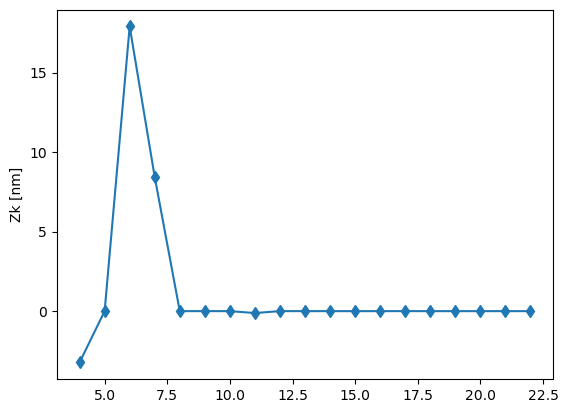

In [113]:
plt.plot(np.arange(4,23), zs[4:]*1e9,'-d')
plt.ylabel('Zk [nm]')

In [104]:
zs[4:]*1e9

array([-3.22728490e+00, -3.55000158e-15,  1.78933690e+01,  8.42954168e+00,
        7.26577753e-15,  4.33032629e-04, -1.84742021e-15, -1.19750172e-01,
        1.77579598e-03,  1.01950299e-15,  2.06400984e-07,  6.61910770e-15,
        4.98912994e-15,  8.69112836e-04,  7.01708985e-15,  5.62248823e-07,
        4.85798528e-15,  2.43578621e-07, -6.10464445e-04])

Why doesn't it look anywhere close to `M2_modes` ? Is it really the "truth" ? 

Try fitting with `ts_wep` : 

In [129]:
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage

fieldXY = np.zeros(2)

instName = 'auxTel'
opticalModel = 'onAxis'
sizeInPix = 220 # here we make bigger stamps than the usual 200  # donut stamp size 
suffix = 'auxTel'
configDir = getConfigDir()
algoDir = os.path.join(configDir, "cwfs", "algo")
tol=1e-3

# this is part of the init
inst = Instrument()
algo = Algorithm(algoDir)

# inside estimateZernikes()
camType = getCamType(instName)

# inside wfEsti.config
inst.configFromFile(sizeInPix, camType)

# choose the solver for the algorithm
solver = 'exp' # by default
debugLevel = 1 # 1 to 3
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

fieldXYIntra = fieldXY
fieldXYExtra = fieldXYIntra

# now inside  `wfEsti.setImg` method,
# which inherits from `CompensableImage`
imgExtra.setImg(fieldXYExtra,
                DefocalType.Extra,
                image = extra_stamp)
#                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

imgIntra.setImg(fieldXYIntra,
                DefocalType.Intra,
                image = intra_stamp)
#               image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

boundaryT = algo.getBoundaryThickness()

# right after we set the image, the compensable image mask is empty -
# it is only calculated later in Algorithm
#maskScalingFactorLocal = 1

# algo, store = func.runIt_store(algo, imgIntra, imgExtra, model=opticalModel, 
#                           tol=1e-3,doCoCenter=doCoCenter)

# rename to just like it is in Algorithm.py
algo.runIt(imgIntra, imgExtra, opticalModel, tol=tol)

zer4UpInNm = algo.getZer4UpInNm()



# output from wep are in microns, need to convert to nm.
zern = [
    -zer4UpInNm[4] * 1e3,
    zer4UpInNm[3] * 1e3,
   zer4UpInNm[0] * 1e3,
]

In [130]:
zer4UpInNm

array([ 3.16361673, -2.31986299,  6.35454492, 10.61313301, -0.16735396,
        0.39889892,  0.92793016, -0.23343752, -0.17891586,  0.19113123,
       -3.22045819, -0.36602907, -0.28851364, -1.80955657, -0.03775103,
       -0.41575654,  0.70291157,  1.65599527,  0.09647041])

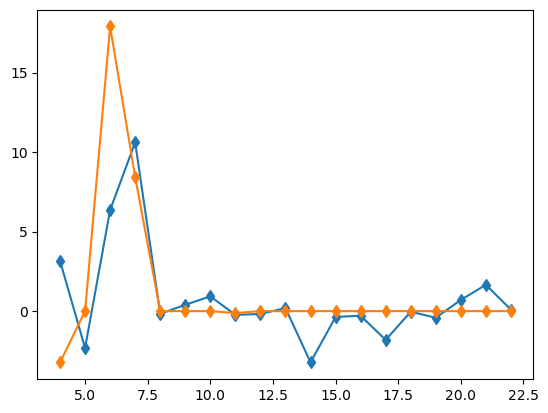

In [134]:
plt.plot(np.arange(4,23), zer4UpInNm, '-d', label='ts_wep')
plt.plot(np.arange(4,23), zs[4:]*1e9,'-d', label='truth')

I'm not sure if that's the correct fit ... Why is it so far off ? 